<a href="https://colab.research.google.com/github/someshkr/Geo-Copula/blob/main/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
!pip install geopy
!pip install geopandas
!pip install shapely
!pip install fiona
!pip install pyproj 
!pip install rtree
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 38.3 MB/s 
     |████████████████████████████████| 16.7 MB 511 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 5.1 MB/s 
  Installing build 


**Importing the libraries**

In [5]:
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rtree
import shapely
import fiona
import pyproj


In [6]:
# df = pd.read_excel("/content/query.xlsx")

df = pd.read_excel("/content/drive/MyDrive/geocopula/query.xlsx")
# df = pd.read_csv("/dbfs/FileStore/data/Indian_earthquake_data.csv")
df['time'] = pd.to_datetime(df['time'],utc=True)
df = df[['time','latitude','longitude','depth','mag']]
df = df.sort_values(by='time',ascending=True)
df.head()

,time,latitude,longitude,depth,mag
17836,2000-09-17 05:18:04.270000+00:00,38.006,140.670,105.1,4.5
17835,2000-09-17 21:04:24.900000+00:00,30.257,138.392,445.6,4.3
17834,2000-09-21 22:43:24.770000+00:00,35.811,140.837,45.2,4.8
17833,2000-09-23 17:42:10.600000+00:00,41.444,142.217,63.9,4.3
17832,2000-09-25 16:22:01.020000+00:00,32.167,142.461,33.0,4.1


In [96]:
df_train = df.iloc[:12512]
df_val = df.iloc[12512:14271]
df_test = df.iloc[14271:]
df_train = df_train.set_index('time')
df_val = df_val.set_index('time')
df_test = df_test.set_index('time')

In [97]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

In [98]:
x_train.shape

(12512, 3)

In [99]:
batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

In [100]:
print("x_train shape ",x_train.shape)
print("x_test shape ",x_test.shape)
print("x_val shape ",x_val.shape)
print("y_train shape ",y_train.shape)
print("y_test shape ",y_test.shape)
print("y_val shape ",y_val.shape)
print(val_iterator)
print(test_iterator)

x_train shape  (12512, 3, 1)
x_test shape  (3566, 3, 1)
x_val shape  (1759, 3, 1)
y_train shape  (12512, 1)
y_test shape  (3566, 1)
y_val shape  (1759, 1)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


# **Bi-directional LSTM**

In [101]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#model.add(tf.keras.layers.Reshape((128, 1), input_shape = (128, )))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [102]:
n_steps,n_features

(3, 1)

In [103]:
# train_iterator
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [104]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 11s 8ms/step - loss: 0.4869 - val_loss: 0.1368
Epoch 2/10
800/800 [==============================] - 5s 7ms/step - loss: 0.2335 - val_loss: 0.1375
Epoch 3/10
800/800 [==============================] - 5s 7ms/step - loss: 0.2335 - val_loss: 0.1542
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2333 - val_loss: 0.1403
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2361 - val_loss: 0.1633
Epoch 6/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2329 - val_loss: 0.1412
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2322 - val_loss: 0.1521
Epoch 8/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2334 - val_loss: 0.1421
Epoch 9/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2312 - val_loss: 0.1677
Epoch 10/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2311 - val_loss: 0.135

In [105]:
len(model.predict(np.array(x_test)).reshape(-1))

112/112 [==============================] - 1s 2ms/step


3566

In [106]:
x_test.shape

(3566, 3, 1)

In [107]:
df_final = df_test.copy()
df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

112/112 [==============================] - 0s 2ms/step


# **CNN LSTM**

In [108]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)



(12512, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [109]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model2 = Sequential()

model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu',input_shape=(None,64,1))))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(10, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

# model.fit(X, y, epochs=500, verbose=0)

In [110]:
print(n_steps,n_features)

3 1


In [111]:
epochs = 5
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model2.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model2.summary()

Epoch 1/5
800/800 [==============================] - 5s 4ms/step - loss: 0.3477 - val_loss: 0.1544
Epoch 2/5
800/800 [==============================] - 3s 3ms/step - loss: 0.2512 - val_loss: 0.1499
Epoch 3/5
800/800 [==============================] - 3s 3ms/step - loss: 0.2480 - val_loss: 0.1633
Epoch 4/5
800/800 [==============================] - 3s 3ms/step - loss: 0.2519 - val_loss: 0.1705
Epoch 5/5
800/800 [==============================] - 3s 4ms/step - loss: 0.2488 - val_loss: 0.1709
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 1, 3, 64)         128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 1, 64)         0         
 tributed)                                                       
                     

In [112]:
len(model2.predict(np.array(x_test)).reshape(-1))

112/112 [==============================] - 1s 2ms/step


3566

In [113]:
x_test.shape

(3566, 1, 3, 1)

In [114]:
df_final2 = df_test.copy()
df_final2['yhat']=model2.predict(np.array(x_test)).reshape(-1)

112/112 [==============================] - 0s 3ms/step


# **ConvLSTM**

In [115]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)

'''
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

X = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))

n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

'''



(12512, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


'\nn_features = 1\nn_seq = 2\nn_steps = 2\nX = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))\n\nX = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))\n\nn_steps = x_train.shape[-2]\nn_features = x_train.shape[-1]\nprint(n_steps,n_features)\n\n'

In [116]:

# define model
model3 = Sequential()
model3.add(ConvLSTM2D(filters=8, kernel_size=(1,2), activation='relu', input_shape=(1, 1,  x_train.shape[-2], x_train.shape[-1])))
model3.add(Flatten())
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [117]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

3 1


In [118]:
epochs = 5
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model3.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model3.summary()

Epoch 1/5
800/800 [==============================] - 7s 5ms/step - loss: 5.6698 - val_loss: 0.5425
Epoch 2/5
800/800 [==============================] - 3s 4ms/step - loss: 0.6891 - val_loss: 0.3440
Epoch 3/5
800/800 [==============================] - 3s 4ms/step - loss: 0.4437 - val_loss: 0.2361
Epoch 4/5
800/800 [==============================] - 4s 4ms/step - loss: 0.3226 - val_loss: 0.1682
Epoch 5/5
800/800 [==============================] - 4s 5ms/step - loss: 0.2699 - val_loss: 0.1489
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 2, 8)           608       
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                     

# **LSTM**

In [30]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)


(12512, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [31]:

# # split a univariate sequence
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.shape)

In [32]:
# # univariate cnn lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# print(X.shape[0], n_seq, n_steps, n_features)
# print(X.shape)
# print(X)
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))


# # define model
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # # fit model
# # model.fit(X, y, epochs=500)
# # # demonstrate prediction
# # x_input = array([60, 70, 80, 90])
# # x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# # yhat = model.predict(x_input, verbose=0)
# # print(yhat)


In [33]:
# epochs = 10
# steps_per_epoch = 800
# validation_steps = 80
# # Train with an infinite dataset
# x_train = np.array(x_train)
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# history = model.fit(x_train, y_train,epochs=epochs,
#                     steps_per_epoch=steps_per_epoch
#                    )
# print('=======================')
# model.summary()

In [34]:

#for batch_num, (x, y) in enumerate(test_iterator.take(3)):
  
len(model3.predict(np.array(x_test)).reshape(-1))

112/112 [==============================] - 0s 2ms/step


3566

In [35]:

# yhat = model.predict(np.array(x_test), verbose=0).reshape(-1)


In [36]:
# x_test.shape

In [37]:
# df_final = df_test.copy()
# df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

In [38]:
df_final.head()

,latitude,longitude,depth,mag,yhat
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,5.3,4.749015
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.2,4.392121
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,6.2,4.630065
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.1,4.597799
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.0,4.594878


In [39]:
# # univariate lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print('++++++++++++++++++++++++++++++++++++++++++++++++')
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.ndim)
# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [119]:
from sklearn.cluster import AgglomerativeClustering

In [127]:
len(df_dend.index)

3566

Text(0, 0.5, 'height')

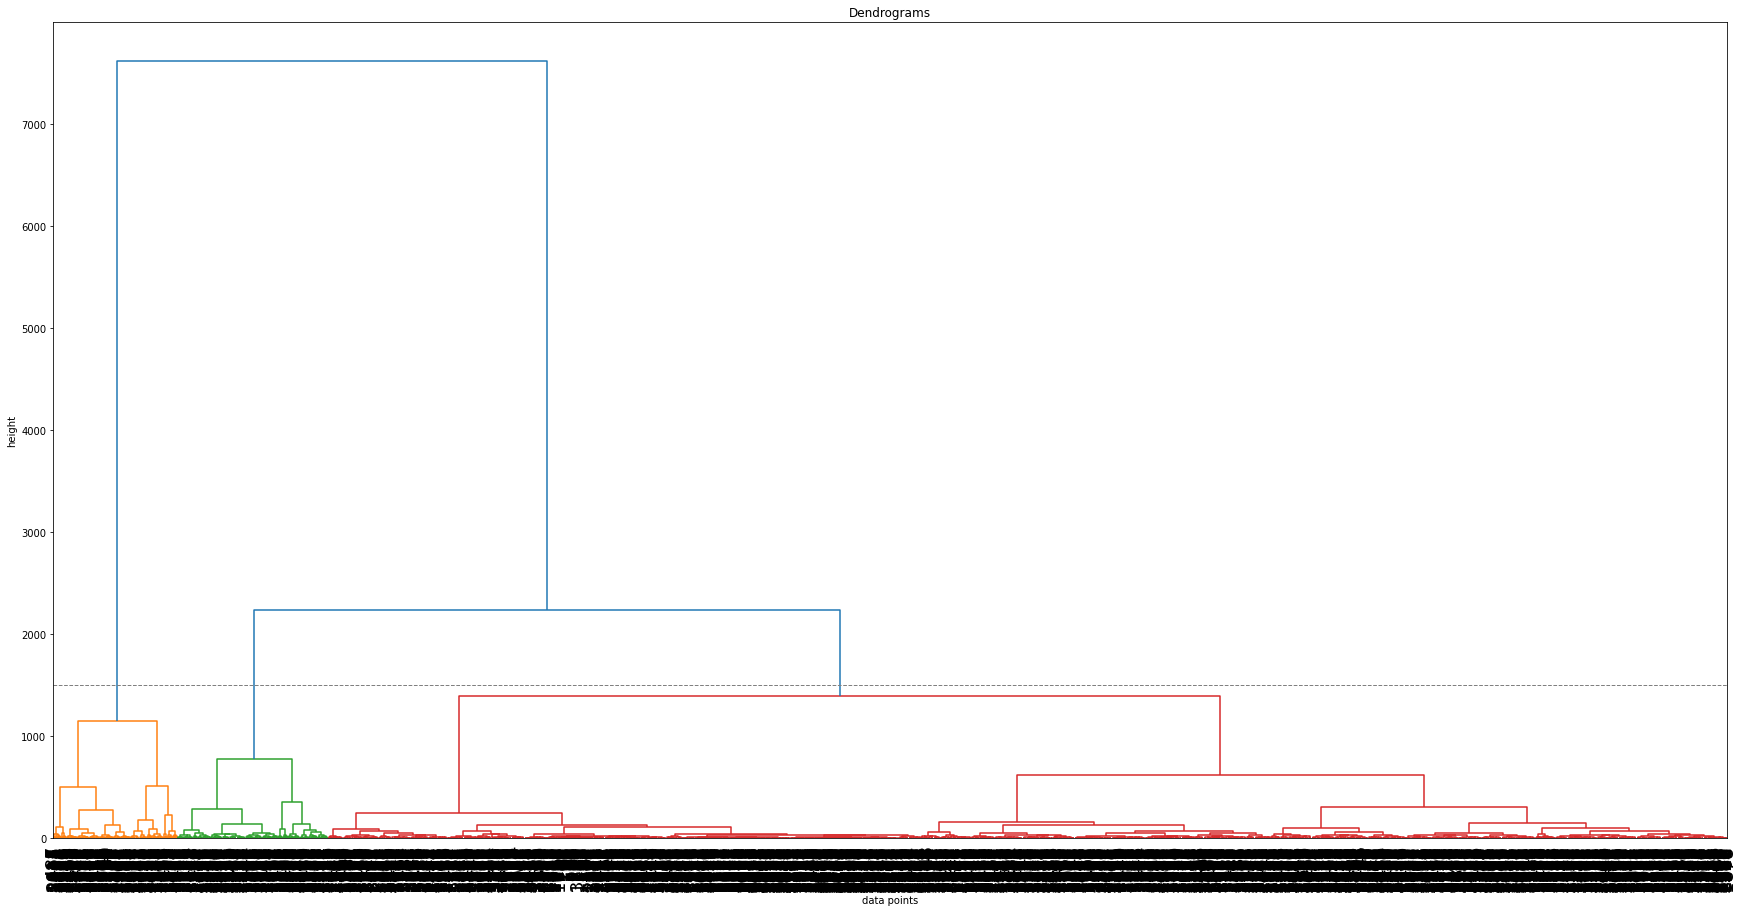

In [131]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(30, 15))  
pyplot.title("Dendrograms")  
df_dend = df_final.drop(['mag'],axis=1) 
dend = shc.dendrogram(shc.linkage(df_dend, method='ward'),leaf_rotation=90,leaf_font_size=18,color_threshold=1500)
pyplot.axhline(y=1500,c='gray',lw=1,linestyle='dashed')
#pyplot.set_xticklabels(np.arange(len(df_dend.index),100))
pyplot.xlabel("data points")
pyplot.ylabel("height")

In [42]:
cluster = AgglomerativeClustering(n_clusters=2).fit(df_dend)
df_dend['labels'] = cluster.labels_

In [43]:
df_dend.head()

,latitude,longitude,depth,yhat,labels
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,4.749015,0
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.392121,0
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,4.630065,0
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.597799,0
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.594878,0


In [44]:
df_dend['labels'].unique()

array([0, 1])

In [45]:
df_1 = df_dend.loc[(df_dend['labels']==0)]
df_2 = df_dend.loc[(df_dend['labels']==1)]
# df_3 = df_dend.loc[(df_dend['labels']==2)]
# df_4 = df_dend.loc[(df_dend['labels']==3)]

# *Plotting the coordinates based on the above cluster*

In [46]:
import fsspec


# with fsspec.open("/content/data.zip") as file:
with fsspec.open("/content/drive/MyDrive/geocopula/japan_data.zip") as file:
    jap = gpd.read_file(file)


# geometry = [Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])]
# gdf = GeoDataFrame(df_1,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='red', markersize=15);

In [47]:

gdf1 = GeoDataFrame(df_1,geometry=[Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])])
gdf2 = GeoDataFrame(df_2,geometry=[Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])])

bb = gdf1[["geometry"]].copy()
bb.reset_index(level=0, inplace=True)
label_1_centroid = bb.dissolve().centroid
print(label_1_centroid)
cc = gdf2[["geometry"]].copy()
cc.reset_index(level=0, inplace=True)
label_2_centroid = cc.dissolve().centroid
print(label_2_centroid)

0    POINT (140.61858 36.09951)
dtype: geometry
0    POINT (137.00146 33.83995)
dtype: geometry


In [48]:
print(np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0))
print(np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0))

[140.61857535  36.09950948]
[137.00146174  33.83994621]


In [49]:
from matplotlib.patches import Circle
import cartopy
from cartopy.geodesic import Geodesic
import cartopy.crs as ccrs
import shapely.geometry as sgeom

In [51]:
X1 = np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0)
X2 = np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0)
print(X1,X2)

[140.61857535  36.09950948] [137.00146174  33.83994621]


In [65]:
pdf = pd.DataFrame({
    "centroids":["label_0","label_1"],
    "Latitude":[np.array(label_1_centroid.y)[0],np.array(label_2_centroid.y)[0]],
    "Longitude":[np.array(label_1_centroid.x)[0],np.array(label_2_centroid.x)[0]]
})

centroid_df = gpd.GeoDataFrame(pdf, geometry=gpd.points_from_xy(pdf.Longitude, pdf.Latitude))
centroid_df

,centroids,Latitude,Longitude,geometry
0,label_0,36.099509,140.618575,POINT (140.61858 36.09951)
1,label_1,33.839946,137.001462,POINT (137.00146 33.83995)


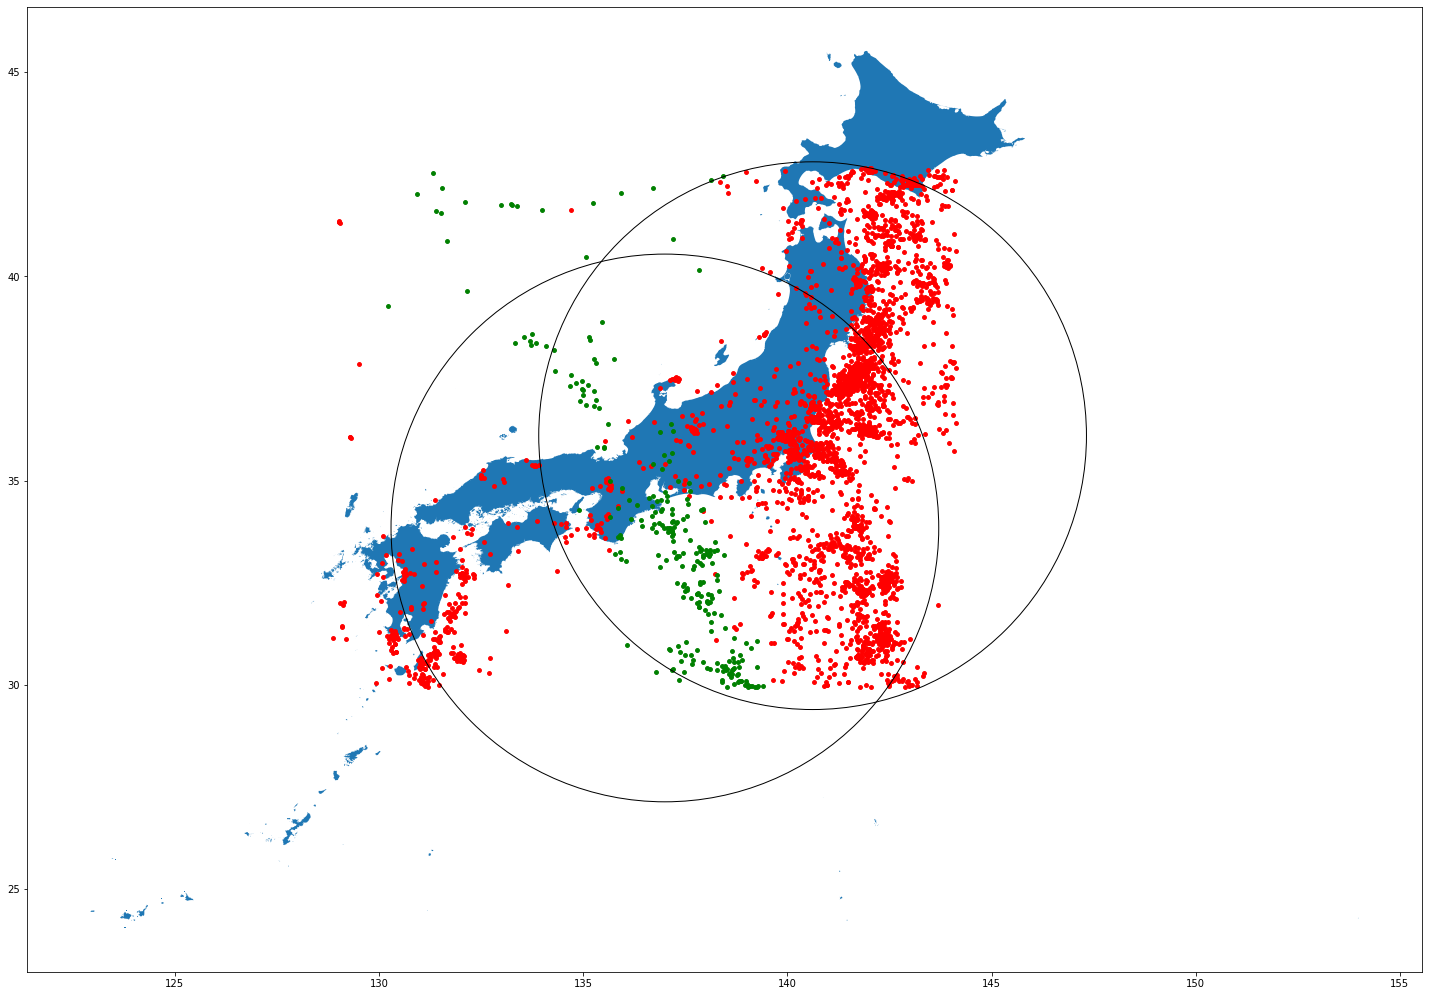

In [94]:

# gdf3 = GeoDataFrame(df_3,geometry=[Point(xy) for xy in zip(df_3['longitude'],df_3['latitude'])])
a = gdf1.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Red', markersize=15);
b = gdf2.plot(ax=a, marker='o', color='Green', markersize=15);
c = centroid_df.plot(ax=b, marker='o', color='Black', markersize=300000,facecolors='none', edgecolors="Black");
# X1 = np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0)
# X2 = np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0)


#fc1.plot(label_2_centroid.x,label_2_centroid.y,'black')
# c = gdf3.plot(ax=b, marker='o', color='Yellow', markersize=15);


In [87]:
# centroid_df.plot(ax=b, marker='o', color='Red', markersize=80000,facecolors='none', edgecolors="red");

<Figure size 432x288 with 0 Axes>

In [65]:
# circle = plt.Circle((X1[0],X1[1]), 2)
# b.add_artist(circle)

In [ ]:
# geometry = [Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])]
# gdf = GeoDataFrame(df_2,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Green', markersize=15);

In [90]:
# fig, gax = plt.subplots(figsize=(25,25))
# b.plot(ax=gax, color='red', alpha = 0.5)

# gax.set_xlabel('longitude')
# gax.set_ylabel('latitude')
# gax.set_title('Japan')

# gax.spines['top'].set_visible(False)
# gax.spines['right'].set_visible(False)

# plt.show()


In [91]:
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon, Point

# # LON, LAT
# vertices = [(i,j) for i in df_1['longitude'].values for j in df_1['latitude'].values]

# p1 = Polygon(vertices)
# print(p1)
# print(p1.area)
# print(p1.bounds)
# print(p1.centroid)

# plt.plot( [v[0] for v in vertices], [v[1] for v in vertices] )
# plt.show()

In [ ]:
#https://github.com/Soroush98/LSTM-CNN_Stock/blob/master/LSTM_CNN.py